In [1]:
from transformers import AutoTokenizer,AutoModel,BertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

## 数据预处理
打算使用bert-cased的预训练模型，预处理主要
* 删除一些乱起八糟的符号（尤其是去除\[\]等表达式）
* 去掉url
* 缩写(不确定是不是需要再进一步处理一下)
* 检查整体的长度


* 句子末尾莫名其妙的数字
* 首尾的标点符号

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [6]:
raw_dataset = pd.read_csv(r'E:\0kaggle\train.csv',encoding='utf-8')

In [7]:
raw_dataset

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


选取了前100条comment_text作为sample分析普遍存在的问题：
* 末尾的数字93.161.107.169 : 0 10
* (talk) 21:51, January 11, 2016 (UTC) 18:01, 16 Jun 2005 (UTC) 27
* 首尾的"" '' 5 7
* · talk 5
* (talk • contribs • ) 10
* @ | talk .12 
*  -''''''The '45 " 20
* 去除url 22 33
* ] 32
*  ++: t/c 结尾
* (talk•contribs)
* 70.100.229.154  04:28:57, August 19, 2007 (UTC) 37

总结一下：
1. 数字 xx.xx.xx.xx
2. 首尾的"" ''
3. ·@ | + []去掉
4. 去除url
5. 去除时间 (xx:)xx:xx, 月份 年份(UTC)
顺序：2 4 3 5 1

In [4]:
import re
from bs4 import BeautifulSoup

In [66]:
re.sub(r'\d+\.\d+\.\d+\.\d+','',a)#1
str.strip('"')#2
BeautifulSoup('<br>').get_text()#去除url等 4
re.sub(r'[·@|\+\[\]]','',a)#3
'(\d+:)?\d+:\d+,\s?\w+\s?\d+,\s?\d{4}\s\(UTC\)'#5 21:51, January 11, 2016 (UTC) 18:01
re.sub(r'(\d+:)?\d+:\d+,\s?\d+\s?\w+\s?\d{4}\s\(UTC\)','',a)#5
re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b(\/\S+)*','',a)#补充 去除网址
#去除nan

"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? "

## 去除

In [23]:
def preprocess(text):
    #去除首尾"
    text = text.strip('"')
    #去除utl
    #text = BeautifulSoup(text).get_text()   
    #print(text)
    #去除网址
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b(\/\S+)*',' ',text)
    #去除某些没啥意义的符号
    text = re.sub(r'[@|\+\[\]]',' ',text)
    text = re.sub(r'•',' ',text)
    text = re.sub(r'={2,}|\'{2,}|\:{2,}|\"{2,}',' ',text)
    #去除日期
    text = re.sub(r'(\d+:)?\d+:\d+,\s?\d+\s?\w+\s?\d{4}\s\(UTC\)',' ',text)
    text = re.sub(r'(\d+:)?\d+:\d+,\s?\w+\s?\d+,\s?\d{4}\s\(UTC\)',' ',text)    
    #去除类似于ip地址一样的数字
    text = re.sub(r'\d+\.\d+\.\d+\.\d+',' ',text)   
    return text
#一定记得用空格来取代，不然会产生nan

In [24]:
raw_dataset = pd.read_csv(r'E:\0kaggle\train.csv',encoding='utf-8')
raw_dataset.comment_text = raw_dataset.comment_text.apply(preprocess)

In [25]:
raw_dataset.to_csv(r'E:\0kaggle\preprocess\train_url.csv',index=False)
raw_dataset

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,\nMore\nI can't make any real suggestions on i...,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,"And for the second time of asking, when your ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [26]:
#测试集数据同样处理
raw_dataset = pd.read_csv(r'E:\0kaggle\test.csv',encoding='utf-8')
raw_dataset.comment_text = raw_dataset.comment_text.apply(preprocess)
raw_dataset.to_csv(r'E:\0kaggle\preprocess\test_url.csv',index=False)
raw_dataset

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,"From RfC \n\n The title is fine as it is, ..."
2,00013b17ad220c46,\n\n Sources \n\n * Zawe Ashton on Laplan...
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,Throw from out field to home plate. \n\n D...
153161,fffda9e8d6fafa9e,\n\n Okinotorishima categories \n\n I see...
153162,fffe8f1340a79fc2,\n\n One of the founding nations of the EU...


## preprocess之后，产生了很多comment_text为nan的情况
通过修正preprocess函数，不会出现nan的情况

In [27]:
raw_dataset = pd.read_csv(r'E:\0kaggle\preprocess\train_url.csv',encoding='utf-8')
len(raw_dataset.dropna())-len(raw_dataset)

0

In [28]:
raw_dataset = pd.read_csv(r'E:\0kaggle\preprocess\test_url.csv',encoding='utf-8')
len(raw_dataset.dropna())-len(raw_dataset)

0

## 检查长度

In [35]:
raw_dataset = pd.read_csv(r'E:\0kaggle\preprocess\train_url.csv',encoding='utf-8')
raw_dataset

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,\nMore\nI can't make any real suggestions on i...,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,"And for the second time of asking, when your ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [44]:
word_list=list( raw_dataset['comment_text'])
len_list=[]
except_list=[]
except_id=[]
except_class=[]
for i in range(len(word_list)):
    try:
        a=tokenizer(word_list[i])
        len_list+=[len( a['input_ids'] )]
    except:
        except_id.append(i)
        except_list.append(word_list[i])
        except_class.append( list(raw_dataset.iloc[i,-6:]) )

In [40]:
len(word_list)#样本量

159571

In [46]:
len(len_list)

159571

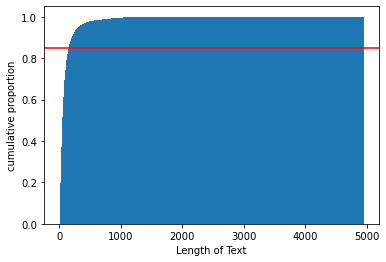

In [51]:
# 画图，横轴为文本长度，纵轴为数据累计占比
plt.hist(len_list, 2000, density=True, stacked=True, cumulative=True)
plt.xlabel('Length of Text')
plt.ylabel('cumulative proportion')
plt.axhline(y=0.85, c='r')
plt.show()

In [63]:
len_list.sort()
pd.Series(len_list).describe(percentiles=[.25,.5,.75,.8,.85,.9,.95,.98])

count    159571.000000
mean         95.017823
std         149.736918
min           2.000000
25%          26.000000
50%          51.000000
75%         103.000000
80%         124.000000
85%         154.000000
90%         206.000000
95%         310.000000
98%         536.000000
max        4950.000000
dtype: float64

最大长度512没毛病

## 检查原本数据集是否有空的

In [86]:
raw_dataset = pd.read_csv(r'E:\0kaggle\train.csv',encoding='utf-8')

In [87]:
len(raw_dataset.dropna())-len(raw_dataset)

0

没有，在预处理时有的直接删除了才产生的nan

In [19]:
raw_dataset = pd.read_csv(r'E:\0kaggle\train.csv',encoding='utf-8')
raw_dataset.loc[except_id]['comment_text'].to_csv('nan都是啥.csv')

去除url的操作错误清楚了很多内容，因此需要重新预处理。之后，再观察训练集里的nan是不是没有任何攻击性。如果是的话，可以根据规则来盯一下.

结论：确实是，训练集中的nan都是因为comment_text都是时间戳。

## 草稿本

### automodel和bertmodel去from_pretrained同一个模型是不是一样的
结论：好像一样

In [2]:
model = AutoModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### model的output有啥

In [28]:
a = tokenizer('i love island.',return_tensors = 'pt')
output = model(**a)


In [29]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [22]:
a

{'input_ids': [101, 178, 1567, 2248, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

### 预训练模型在默认情况下是否可以微调

In [11]:
i=[]
for param in model.parameters():
    i+=[param.requires_grad]
i

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

预训练模型默认情况下参数是可以微调的

### 如果进行截断的话，会不会保留末尾的[sep]

In [2]:
tokenizer('i am a pig.')

{'input_ids': [101, 178, 1821, 170, 13407, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [3]:
tokenizer('i am a pig.',truncation = True,max_length = 3)

{'input_ids': [101, 178, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

###  模型输出

In [14]:
seqs = ['i am a pig.',
       'you are so nice!',
       'hey,dude!']
input=tokenizer(seqs,return_tensors = 'pt',padding = 'longest')
output_dict = model(**input,return_dict=True, output_hidden_states=True)
#output = model(**input)

In [12]:
#output.last_hidden_state.shape #经过padding之后是等shape的
#output.pooler_output.shape#每个seq的[CLS]

torch.Size([3, 768])

In [20]:
len(output_dict.hidden_states)#提供每一层

13

In [21]:
output_dict.hidden_states# (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size)

(tensor([[[ 0.4496,  0.0977, -0.2074,  ...,  0.0578,  0.0406, -0.0951],
          [-1.3978, -0.6951,  0.7486,  ..., -0.2430,  0.6545,  0.4492],
          [-1.0983,  1.1475, -0.7432,  ..., -0.8759,  0.5111,  1.0665],
          ...,
          [ 0.2427, -1.0620,  0.7731,  ..., -0.4553, -0.1598, -0.6102],
          [-0.6770,  0.9491,  0.7780,  ...,  0.1771,  0.3663, -0.1019],
          [-0.2318, -0.1106,  0.2459,  ...,  0.6098, -0.7149,  0.4329]],
 
         [[ 0.4496,  0.0977, -0.2074,  ...,  0.0578,  0.0406, -0.0951],
          [ 0.0970, -0.4725, -0.0998,  ...,  0.8076,  0.3889,  0.3692],
          [-1.3004,  0.3671, -0.6442,  ...,  0.5829,  0.6138,  1.0224],
          ...,
          [ 0.2575, -0.8289, -0.6601,  ..., -0.5699,  0.5695,  0.3717],
          [-0.5619,  1.1386,  0.1605,  ...,  0.8117, -0.7611, -0.2321],
          [-0.2318, -0.1106,  0.2459,  ...,  0.6098, -0.7149,  0.4329]],
 
         [[ 0.4496,  0.0977, -0.2074,  ...,  0.0578,  0.0406, -0.0951],
          [-0.6068, -0.7429,

In [25]:
output_dict.last_hidden_state.shape

torch.Size([3, 7, 768])

In [26]:
output_dict.pooler_output.shape

torch.Size([3, 768])

In [29]:
import torch
torch.equal(output.last_hidden_state[-1],output.pooler_output)
#pooler_output是last_hidden_state中[CLS]的输出经过一个nn和激活函数的结果，其中nn的权重是在NSP中预训练得到的

False

### 删除submission的index列

In [2]:
raw_dataset = pd.read_csv(r'E:\0kaggle\submission.csv',encoding='utf-8')

In [5]:
raw_dataset.iloc[:,1:].to_csv(r'E:\0kaggle\submission.csv',encoding='utf-8',index=False)

### 选取几个毒评论的例子

In [2]:
raw_dataset = pd.read_csv(r'E:\0kaggle\preprocess\train_url.csv',encoding='utf-8')

In [3]:
raw_dataset['sum']=raw_dataset.apply(lambda x:x[-6:].sum(),axis=1)


In [4]:
raw_dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,\nMore\nI can't make any real suggestions on i...,0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [5]:
raw_dataset.loc[raw_dataset['sum']==4]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,4
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1,4
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0,4
...,...,...,...,...,...,...,...,...,...
159096,f871b05d4caa6f20,"You filthy, stinking crow! \n\nI am back! Dirt...",1,1,1,0,1,0,4
159099,f885a3e2d779342e,now\n\nyou fucking pathetic moron. \n\ncc: Ji...,1,1,1,0,1,0,4
159312,fbf20e312cd4a78d,"Walter Mercado \n\nAntonio, quite frankly, you...",1,1,1,0,1,0,4
159336,fc3efa2f6f025f6d,"Oh, fuck off. The pansy Jew would just whine a...",1,0,1,0,1,1,4


In [6]:
raw_dataset.iloc[55].comment_text

'Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!'

### 类别比例

In [30]:
raw_dataset=raw_dataset.drop(columns=['id','comment_text'])

In [34]:
raw_dataset.loc['row_sum']=raw_dataset.apply(lambda x:x.sum())

In [35]:
raw_dataset

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
159567,0,0,0,0,0,0,0
159568,0,0,0,0,0,0,0
159569,0,0,0,0,0,0,0
159570,0,0,0,0,0,0,0


In [46]:
raw_dataset.loc[raw_dataset['sum']==0]

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,0,0,0,0,0,0,0
159567,0,0,0,0,0,0,0
159568,0,0,0,0,0,0,0
159569,0,0,0,0,0,0,0


* 一共159571句话
* 完全无毒的句子 143346
* 有毒的句子中，'toxic','severe_toxic','obscene','threat','insult','identity_hate'分别占15294，1595，8449，478，7877，1405	